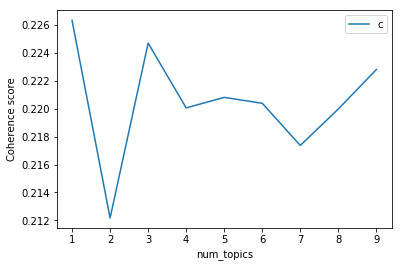

(0, '0.000*"apple" + 0.000*"computer" + 0.000*"iphone" + 0.000*"new"')
(1, '0.069*"apple" + 0.015*"computer" + 0.013*"new" + 0.011*"iphone"')
(2, '0.001*"apple" + 0.000*"computer" + 0.000*"new" + 0.000*"iphone"')
(3, '0.000*"apple" + 0.000*"computer" + 0.000*"new" + 0.000*"iphone"')
(4, '0.001*"apple" + 0.000*"iphone" + 0.000*"computer" + 0.000*"new"')


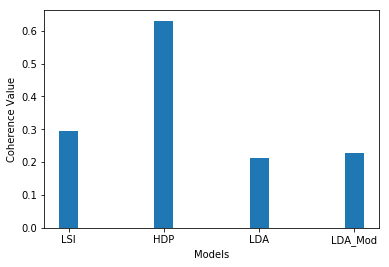

In [6]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Dec 10 11:08:31 2018

@author: ly
"""

#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Dec  9 22:30:06 2018

@author: ly
"""
# Reference：
# https://markroxor.github.io/gensim/static/notebooks/gensim_news_classification.html

import os
import matplotlib.pyplot as plt
import warnings
import gensim
import numpy as np
import pickle
import pandas as pd
import pyLDAvis.gensim

warnings.filterwarnings('ignore')  # Ignore possible warnings 

from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.corpora import Dictionary


from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

import spacy
spacy.load('en')
from spacy.lang.en import English

# Read and combine the text data into two documents 
df_test = pd.read_csv("News/apple-incorporated.txt",sep = '\t',
                      encoding = 'utf-8',header = None)
df_test.columns = ['Date','Title','Summary']

title_doc = df_test['Title'].to_string(header = False, index=False)
summary_doc= df_test['Summary'].to_string(header = False, index=False)
docs = [title_doc, summary_doc]


def tokenize(text):
    """
    Function to tokenize texts. Following are the steps we take:
    1. Tokenize Documents
    2. Space Removal.
    3. Punctuation Removal

    Parameters:
    ----------
    doc: Untokenized texts.

    Returns:
    -------
    tokens: Tokenized texts.
    """
    # Use the English parser from Spacy
    parser = English()
    spacy_tokens = []
    tokens = parser(text)
    for token in tokens:
        # Remove space 
        if token.orth_.isspace(): 
            continue
        # Remove punctuation
        elif token.is_punct:
            continue
        # Keep only the remaining words and change to clowercase 
        else:
            spacy_tokens.append(token.lower_)
    return spacy_tokens


def process_texts(doc):
    """
    Function to process texts. Following are the steps we take:
    1. Tokenize Documents
    2. Stopword Removal.
    3. Lemmatization

    Parameters:
    ----------
    doc: Untokenized texts.

    Returns:
    -------
    tokens: Tokenized texts.
    """
    
    stops = set(stopwords.words('english')) # nltk stopwords list
    lemma = WordNetLemmatizer() # Lemmatize 
    
    tokens = tokenize(doc)
    tokens = [token for token in tokens if len(token) >= 3]
    tokens = [token for token in tokens if token not in stops]
    tokens = [lemma.lemmatize(token) for token in tokens]
    return tokens

doc_clean = [process_texts(doc) for doc in docs]

# Finalize the dictionary and corpus
dictionary = Dictionary(doc_clean)
corpus = [dictionary.doc2bow(doc) for doc in doc_clean]

# LSI Model
lsimodel = LsiModel(corpus=corpus, num_topics=10, id2word=dictionary)
lsimodel.show_topics(num_topics=20)  # Showing only the top 5 topics
lsitopics = lsimodel.show_topics(formatted=False)

# HDP(Hierarchical Dirichlet Process) Model
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)
hdpmodel.show_topics(num_topics=5)
hdptopics = hdpmodel.show_topics(formatted=False)

# LDA model
ldamodel = LdaModel(corpus=corpus, num_topics=10, id2word=dictionary)
ldamodel.show_topics(num_topics=5)
ldatopics = ldamodel.show_topics(formatted=False)

# LDA_Mod Optimized number of topics
def evaluate_graph(dictionary, corpus, texts, limit):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respect to the number of topics
    """
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v

lmlist, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=doc_clean, limit=10)
lmtopics = lmlist[5].show_topics(formatted=False)



# Coherence Value Comparison
lsitopics = [[word for word, prob in topic] for topicid, topic in lsitopics]

hdptopics = [[word for word, prob in topic] for topicid, topic in hdptopics]

ldatopics = [[word for word, prob in topic] for topicid, topic in ldatopics]

lmtopics = [[word for word, prob in topic] for topicid, topic in lmtopics]

lsi_coherence = CoherenceModel(topics=lsitopics[:10], texts=doc_clean, dictionary=dictionary, window_size=10).get_coherence()

hdp_coherence = CoherenceModel(topics=hdptopics[:10], texts=doc_clean, dictionary=dictionary, window_size=10).get_coherence()

lda_coherence = CoherenceModel(topics=ldatopics, texts=doc_clean, dictionary=dictionary, window_size=10).get_coherence()

lm_coherence = CoherenceModel(topics=lmtopics, texts=doc_clean, dictionary=dictionary, window_size=10).get_coherence()

def evaluate_bar_graph(coherences, indices):
    """
    Function to plot bar graph.
    
    coherences: list of coherence values
    indices: Indices to be used to mark bars. Length of this and coherences should be equal.
    """
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')
    plt.savefig('Coherence Value - Models.png',dpi=400)

evaluate_bar_graph([lsi_coherence, hdp_coherence, lda_coherence, lm_coherence],
                   ['LSI', 'HDP', 'LDA', 'LDA_Mod'])


# LDA Visualzation
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

NUM_TOPICS = 5
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('model5.gensim')
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

ldamodel = LdaModel(corpus=corpus, num_topics=10, id2word=dictionary)
pyLDAvis.enable_notebook()
lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(lda_display)











